https://www.kaggle.com/competitions/playground-series-s4e8

In [1]:
from fastkaggle import *
from pathlib import Path
import zipfile
import pandas as pd
import polars as pl
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, matthews_corrcoef
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from scipy import stats
import seaborn as sns 
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
import numpy as np
from lightgbm import LGBMClassifier
from dython.nominal import associations
from typing import List, Union, Optional, Any

In [2]:
comp_name = "playground-series-s4e8"

In [3]:
setup_comp(comp_name)

Path('playground-series-s4e8')

In [4]:
datapath = Path(comp_name)

In [5]:
df_train = pl.read_csv(f'{datapath}/train.csv')

In [6]:
df_train.head()

id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
i64,str,f64,str,str,str,str,str,str,str,f64,f64,str,str,str,str,str,str,str,str,str,str
0,"""e""",8.8,"""f""","""s""","""u""","""f""","""a""","""c""","""w""",4.51,15.39,null,null,"""w""",null,null,"""f""","""f""",null,"""d""","""a"""
1,"""p""",4.51,"""x""","""h""","""o""","""f""","""a""","""c""","""n""",4.79,6.48,null,"""y""","""o""",null,null,"""t""","""z""",null,"""d""","""w"""
2,"""e""",6.94,"""f""","""s""","""b""","""f""","""x""","""c""","""w""",6.85,9.93,null,"""s""","""n""",null,null,"""f""","""f""",null,"""l""","""w"""
3,"""e""",3.88,"""f""","""y""","""g""","""f""","""s""",null,"""g""",4.16,6.53,null,null,"""w""",null,null,"""f""","""f""",null,"""d""","""u"""
4,"""e""",5.85,"""x""","""l""","""w""","""f""","""d""",null,"""w""",3.37,8.36,null,null,"""w""",null,null,"""f""","""f""",null,"""g""","""a"""


In [7]:
print(f"There are {df_train.shape[1]} columns and {df_train.shape[0]} rows in the train dataset.")


There are 22 columns and 3116945 rows in the train dataset.


In [8]:
df_train.schema

Schema([('id', Int64),
        ('class', String),
        ('cap-diameter', Float64),
        ('cap-shape', String),
        ('cap-surface', String),
        ('cap-color', String),
        ('does-bruise-or-bleed', String),
        ('gill-attachment', String),
        ('gill-spacing', String),
        ('gill-color', String),
        ('stem-height', Float64),
        ('stem-width', Float64),
        ('stem-root', String),
        ('stem-surface', String),
        ('stem-color', String),
        ('veil-type', String),
        ('veil-color', String),
        ('has-ring', String),
        ('ring-type', String),
        ('spore-print-color', String),
        ('habitat', String),
        ('season', String)])

In [9]:
df_train.null_count()

id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,4,40,671023,12,8,523936,1258435,57,0,0,2757023,1980861,38,2957493,2740947,24,128880,2849682,45,0


In [10]:
df_train.to_pandas().isnull()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,False,False,False,False,False,False,False,False,False,False,...,True,True,False,True,True,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,...,True,False,False,True,True,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,...,True,False,False,True,True,False,False,True,False,False
3,False,False,False,False,False,False,False,False,True,False,...,True,True,False,True,True,False,False,True,False,False
4,False,False,False,False,False,False,False,False,True,False,...,True,True,False,True,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116940,False,False,False,False,True,False,False,True,True,False,...,False,True,False,False,False,False,False,True,False,False
3116941,False,False,False,False,True,False,False,False,False,False,...,True,True,False,True,True,False,False,True,False,False
3116942,False,False,False,False,False,False,False,False,True,False,...,True,True,False,True,False,False,False,True,False,False
3116943,False,False,False,False,False,False,False,False,True,False,...,True,False,False,True,True,False,False,True,False,False


In [11]:
df_train_nulls = df_train.to_pandas().isnull()

Visualize missing data 

In [12]:
# plt.figure(figsize=(18,12))
# plt.title("Visualizing Missing Values")
# sns.heatmap(df_train_nulls, cbar=False, cmap=sns.color_palette("Spectral_r", n_colors=13), yticklabels=False);

In [13]:
df_train.describe()

statistic,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
str,f64,str,f64,str,str,str,str,str,str,str,f64,f64,str,str,str,str,str,str,str,str,str,str
"""count""",3.116945e6,"""3116945""",3.116941e6,"""3116905""","""2445922""","""3116933""","""3116937""","""2593009""","""1858510""","""3116888""",3.116945e6,3.116945e6,"""359922""","""1136084""","""3116907""","""159452""","""375998""","""3116921""","""2988065""","""267263""","""3116900""","""3116945"""
"""null_count""",0.0,"""0""",4.0,"""40""","""671023""","""12""","""8""","""523936""","""1258435""","""57""",0.0,0.0,"""2757023""","""1980861""","""38""","""2957493""","""2740947""","""24""","""128880""","""2849682""","""45""","""0"""
"""mean""",1.558472e6,null,6.309848,null,null,null,null,null,null,null,6.348333,11.153785,null,null,null,null,null,null,null,null,null,null
"""std""",899784.661737,null,4.657931,null,null,null,null,null,null,null,2.699755,8.095477,null,null,null,null,null,null,null,null,null,null
"""min""",0.0,"""e""",0.03,"""0""","""0""","""1""","""2""","""0""","""0""","""0""",0.0,0.0,"""1""","""0""","""1""","""21""","""2""","""10""","""1""","""10 None""","""1""","""a"""
"""25%""",779236.0,null,3.32,null,null,null,null,null,null,null,4.67,4.97,null,null,null,null,null,null,null,null,null,null
"""50%""",1.558472e6,null,5.75,null,null,null,null,null,null,null,5.88,9.65,null,null,null,null,null,null,null,null,null,null
"""75%""",2.337708e6,null,8.24,null,null,null,null,null,null,null,7.41,15.63,null,null,null,null,null,null,null,null,null,null
"""max""",3.116944e6,"""p""",80.67,"""z""","""z""","""z""","""z""","""z""","""y""","""z""",88.72,102.9,"""z""","""z""","""z""","""y""","""z""","""z""","""z""","""y""","""z""","""w"""


In [14]:
df_train.dtypes

[Int64,
 String,
 Float64,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 Float64,
 Float64,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String]

In [15]:
df_train.select(pl.all().approx_n_unique())

id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
3083554,2,3884,75,84,79,27,78,49,64,2736,5828,39,61,60,23,25,24,41,33,53,4


In [16]:
df_train.columns

['id',
 'class',
 'cap-diameter',
 'cap-shape',
 'cap-surface',
 'cap-color',
 'does-bruise-or-bleed',
 'gill-attachment',
 'gill-spacing',
 'gill-color',
 'stem-height',
 'stem-width',
 'stem-root',
 'stem-surface',
 'stem-color',
 'veil-type',
 'veil-color',
 'has-ring',
 'ring-type',
 'spore-print-color',
 'habitat',
 'season']

Drop columns with an NA threshold -- possibly deprecated

In [17]:
med_null_vals = df_train.lazy().with_columns([pl.all().is_null().median()]).collect()[0]

In [18]:
med_null_vals

id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [19]:
null_cols = [col for col in df_train.columns if med_null_vals[col][0] == 1.0]

In [20]:
null_cols

['stem-root', 'stem-surface', 'veil-type', 'veil-color', 'spore-print-color']

Columns with more than XX% null values

In [21]:
# Correctly calculate the total number of rows
total_rows = df_train.height

# Calculate the proportion of nulls for each column and identify columns with > 80% nulls
columns_over_xx_nulls = [
    col for col in df_train.columns if df_train.select(pl.col(col).is_null().sum().alias("null_count")).select(((pl.col("null_count") / total_rows) > 0.95)).to_numpy()[0][0]
]

In [22]:
columns_over_xx_nulls

[]

Drop columns over null threshold

In [23]:
# df_train_cleaned = df_train.drop(columns_over_90_nulls)

In [24]:
df_train_cleaned = df_train

Drop id column

In [25]:
df_train_cleaned.drop_in_place("id")

id
i64
0
1
2
3
4
…
3116940
3116941
3116942


In [26]:
def separate_columns_by_type(df):
    # Identify categorical columns as those with data type pl.Utf8
    cat_cols = [col for col, dtype in df.schema.items() if dtype == pl.Utf8]
    
    # Identify numerical columns as those not listed as categorical
    num_cols = [col for col in df.columns if col not in cat_cols]
    
    return cat_cols, num_cols

In [27]:
cat_cols, num_cols = separate_columns_by_type(df_train_cleaned)

In [28]:
cat_cols

['class',
 'cap-shape',
 'cap-surface',
 'cap-color',
 'does-bruise-or-bleed',
 'gill-attachment',
 'gill-spacing',
 'gill-color',
 'stem-root',
 'stem-surface',
 'stem-color',
 'veil-type',
 'veil-color',
 'has-ring',
 'ring-type',
 'spore-print-color',
 'habitat',
 'season']

Impute values

In [29]:
def fill_missing_values(df, num_cols, cat_cols):
    # Convert Polars DataFrame to Pandas DataFrame for processing
    filled_df = df.to_pandas()
    
    # Replace None with NaN to ensure they are treated as missing by SimpleImputer
    filled_df = filled_df.replace({None: np.nan})
    
    # Replace infinite values with NaN to ensure they are treated as missing
    filled_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Fill missing values in numeric columns with median
    numeric_imputer = SimpleImputer(strategy='median')
    filled_df[num_cols] = numeric_imputer.fit_transform(filled_df[num_cols])

    # Fill missing values in categorical columns with mode
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    filled_df[cat_cols] = categorical_imputer.fit_transform(filled_df[cat_cols])

    # Convert the Pandas DataFrame back to a Polars DataFrame
    filled_df = pl.DataFrame(filled_df)

    return filled_df

In [30]:
# df_train_cleaned = fill_missing_values(df_train_cleaned, num_cols, cat_cols)

In [31]:
df_train_cleaned

class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
str,f64,str,str,str,str,str,str,str,f64,f64,str,str,str,str,str,str,str,str,str,str
"""e""",8.8,"""f""","""s""","""u""","""f""","""a""","""c""","""w""",4.51,15.39,null,null,"""w""",null,null,"""f""","""f""",null,"""d""","""a"""
"""p""",4.51,"""x""","""h""","""o""","""f""","""a""","""c""","""n""",4.79,6.48,null,"""y""","""o""",null,null,"""t""","""z""",null,"""d""","""w"""
"""e""",6.94,"""f""","""s""","""b""","""f""","""x""","""c""","""w""",6.85,9.93,null,"""s""","""n""",null,null,"""f""","""f""",null,"""l""","""w"""
"""e""",3.88,"""f""","""y""","""g""","""f""","""s""",null,"""g""",4.16,6.53,null,null,"""w""",null,null,"""f""","""f""",null,"""d""","""u"""
"""e""",5.85,"""x""","""l""","""w""","""f""","""d""",null,"""w""",3.37,8.36,null,null,"""w""",null,null,"""f""","""f""",null,"""g""","""a"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""e""",9.29,"""f""",null,"""n""","""t""",null,null,"""w""",12.14,18.81,"""b""",null,"""w""","""u""","""w""","""t""","""g""",null,"""d""","""u"""
"""e""",10.88,"""s""",null,"""w""","""t""","""d""","""c""","""p""",6.65,26.97,null,null,"""w""",null,null,"""f""","""f""",null,"""d""","""u"""
"""p""",7.82,"""x""","""e""","""e""","""f""","""a""",null,"""w""",9.51,11.06,null,null,"""y""",null,"""w""","""t""","""z""",null,"""d""","""a"""


Correlation Matrix

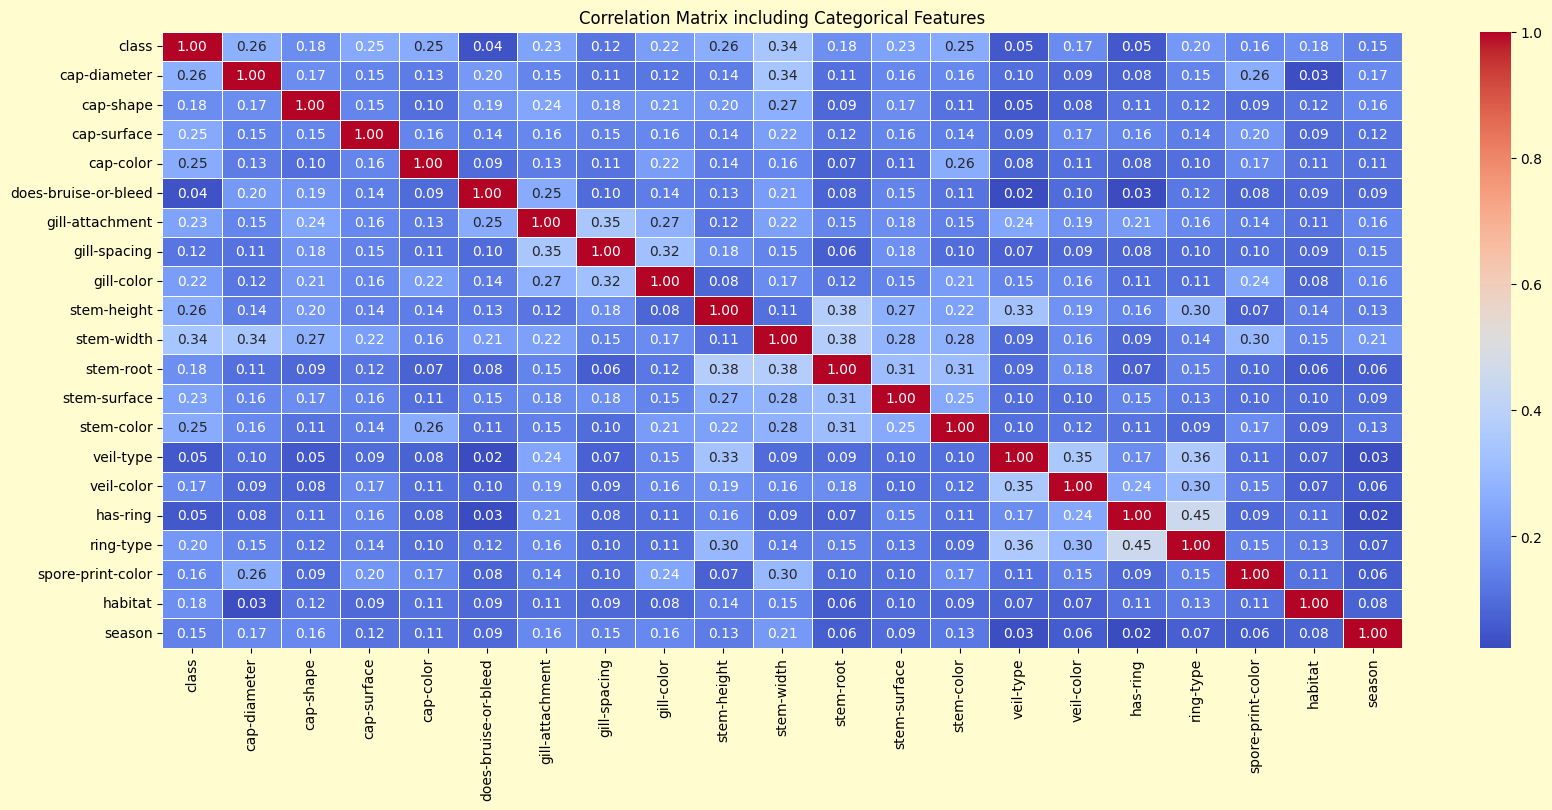

In [32]:
associations_df = associations(df_train_cleaned[:100000].to_pandas(), nominal_columns='all', plot=False)
corr_matrix = associations_df['corr']
plt.figure(figsize=(20, 8))
plt.gcf().set_facecolor('#FFFDD0') 
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix including Categorical Features')
plt.show()

Take a look at the value counts for the target 

In [33]:
df_train['class'].value_counts()

class,count
str,u32
"""e""",1411549
"""p""",1705396


Split the training set into data and target

In [34]:
x = df_train_cleaned.drop('class')
y = df_train_cleaned['class']

For a less ordinal data we could use `One Hot Encoding`, but since the prediction is binary we would can use a basic mapping or sklearn's `LabelEncoder`

In [35]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [36]:
cat_cols = [col for col, dtype in x.schema.items() if dtype == pl.Utf8]
num_cols = [col for col in x.columns if col not in cat_cols]

In [37]:
cat_cols

['cap-shape',
 'cap-surface',
 'cap-color',
 'does-bruise-or-bleed',
 'gill-attachment',
 'gill-spacing',
 'gill-color',
 'stem-root',
 'stem-surface',
 'stem-color',
 'veil-type',
 'veil-color',
 'has-ring',
 'ring-type',
 'spore-print-color',
 'habitat',
 'season']

In [38]:
num_cols

['cap-diameter', 'stem-height', 'stem-width']

Create categorical transformer, handle NaN vals

In [39]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

Create numeric transformer, handle NaN vals

In [40]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')) 
])

In [41]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

Split to training and test sets

In [42]:
x_train, x_test, y_train, y_test = train_test_split(x, y_encoded, test_size=0.2, random_state=42)

In [43]:
y_train[:10]

array([1, 1, 1, 1, 1, 1, 1, 0, 0, 1])

Match x_test to x_train

In [44]:
x_test = x_test[x_train.columns]

In [45]:
def mcc_metric(y_pred, dmatrix):
    y_true = dmatrix.get_label()
    y_pred = (y_pred > 0.5).astype(int)
    mcc = matthews_corrcoef(y_true, y_pred)
    return "mcc", mcc, True

Create a classifier

In [46]:
skl_rf_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(n_estimators=40, max_samples=200_000, random_state=42, verbose=2)),
    ]
)

Gradient Boosting

In [47]:
lgbm_clf = LGBMClassifier(objective='binary', metric="binary_logloss" ,num_leaves=61,
    learning_rate=0.1, n_estimators=700, max_depth=8, random_state=42)

In [48]:
lgbm_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', lgbm_clf)])

Run fit 

In [49]:
def run_fit(clf: Pipeline, x_train: pl.DataFrame, y_train: np.ndarray) -> None:
    x_train_pandas = x_train.to_pandas()
    clf.fit(x_train_pandas, y_train)


In [50]:
def get_preds(clf, x_test: pl.DataFrame) -> np.ndarray:
    return clf.predict(x_test)

In [51]:
models = [lgbm_pipeline]

In [52]:
results = []
for model in models: 
    run_fit(model, x_train, y_train)
    preds = get_preds(model, x_test)
    results.append(preds)

[LightGBM] [Info] Number of positive: 1364404, number of negative: 1129152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.123324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1351
[LightGBM] [Info] Number of data points in the train set: 2493556, number of used features: 296
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547172 -> initscore=0.189251
[LightGBM] [Info] Start training from score 0.189251
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [53]:
def ens_preds(results: List[np.ndarray]):
    return np.mean(np.stack(results, axis=0), axis=0)

In [54]:
ens_preds(results)

array([1., 1., 0., ..., 1., 0., 1.])

Averaging probabilities

In [55]:
def ensemble_probs(results: List[np.ndarray]) -> np.ndarray:
    averaged_probs = np.mean(np.stack(results, axis=0), axis=0)
    class_labels = (averaged_probs > 0.5).astype(int)
    return class_labels

Majority Voting

In [56]:
def ensemble_votes(results: List[np.ndarray]) -> np.ndarray:
    class_labels, _ = np.mode(np.stack(results, axis=0), axis=0)
    return class_labels.ravel() 

Soft Voting

In [57]:
def ensemble_soft_votes(results: List[np.ndarray]) -> np.ndarray:
    averaged_probs = np.mean(np.stack(results, axis=0), axis=0)
    return averaged_probs

In [58]:
for result in results:
    print(matthews_corrcoef(y_test, result))

0.9838824255587321


In [59]:
X_test = pl.read_csv(f'{datapath}/test.csv')

In [60]:
X_test = X_test[x_test.columns]

In [61]:
X_test

cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
f64,str,str,str,str,str,str,str,f64,f64,str,str,str,str,str,str,str,str,str,str
8.64,"""x""",null,"""n""","""t""",null,null,"""w""",11.13,17.12,"""b""",null,"""w""","""u""","""w""","""t""","""g""",null,"""d""","""a"""
6.9,"""o""","""t""","""o""","""f""",null,"""c""","""y""",1.27,10.75,null,null,"""n""",null,null,"""f""","""f""",null,"""d""","""a"""
2.0,"""b""","""g""","""n""","""f""",null,"""c""","""n""",6.18,3.14,null,null,"""n""",null,null,"""f""","""f""",null,"""d""","""s"""
3.47,"""x""","""t""","""n""","""f""","""s""","""c""","""n""",4.98,8.51,null,null,"""w""",null,"""n""","""t""","""z""",null,"""d""","""u"""
6.17,"""x""","""h""","""y""","""f""","""p""",null,"""y""",6.73,13.7,null,null,"""y""",null,"""y""","""t""",null,null,"""d""","""u"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.88,"""x""","""g""","""w""","""f""","""a""","""d""","""w""",2.67,1.35,null,null,"""e""",null,null,"""f""","""f""",null,"""d""","""u"""
3.12,"""x""","""s""","""w""","""f""","""d""","""c""","""w""",2.69,7.38,null,null,"""w""",null,null,"""f""","""f""",null,"""g""","""a"""
5.73,"""x""","""e""","""e""","""f""","""a""",null,"""w""",6.16,9.74,null,null,"""y""",null,"""w""","""t""","""z""",null,"""d""","""a"""


Run lgbm 

In [62]:
preds = lgbm_pipeline.predict(X_test)

In [63]:
label_encoder.inverse_transform(preds)

array(['e', 'p', 'p', ..., 'p', 'e', 'e'], dtype='<U1')

In [64]:
sample_df = pd.read_csv(datapath/'sample_submission.csv')

In [65]:
sample_df.head()

,id,class
0,3116945,e
1,3116946,e
2,3116947,e
3,3116948,e
4,3116949,e


In [66]:
decoded_preds = label_encoder.inverse_transform(preds)

In [67]:
sample_df['class'] = decoded_preds

In [68]:
sample_df

,id,class
0,3116945,e
1,3116946,p
2,3116947,p
3,3116948,p
4,3116949,e
...,...,...
2077959,5194904,p
2077960,5194905,p
2077961,5194906,p
2077962,5194907,e


In [69]:
sample_df.to_csv('submission.csv', index=False)


In [70]:
submit = True

In [71]:
if not iskaggle and submit:
    from kaggle import api
    api.competition_submit_cli(file_name='submission.csv', message="baseline model", competition=comp_name)

100%|██████████| 19.8M/19.8M [00:08<00:00, 2.50MB/s]
